In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/aras/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                    labels=tf.zeros_like(gQs_notequal))) # 0-1
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
    #     rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
    #     dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
    #                                                                     labels=rates_equal)) # 0-1
    #     targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
    #     dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
    #                                                                     labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ, gQs_notequal, gQs_equal

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ, self.gQs_notequal, self.gQs_equal = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

/home/aras/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _, glossQ, dlossQ = sess.run([model.d_loss, model.d_opt, 
                                                 model.g_lossQ, model.d_lossQ],
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _, gQs_notequal, gQs_equal = sess.run([model.g_loss, model.g_opt, 
                                                          model.gQs_notequal, model.gQs_equal], 
                                              feed_dict = {model.states: states, 
                                                           model.actions: actions,
                                                           model.targetQs: targetQs, 
                                                           model.rates: rates})
            #if len(gQs_nonequal) != len(nextQs):
            # if dloss is np.nan:            
            #     print(gQs_notequal.shape, gQs_notequal.dtype)
            #     print(gQs_equal.shape, gQs_equal.dtype)
            #     print(nextQs.shape)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 gloss:1.3568 dloss:2.0302 glossQ:1.0640 dlossQ:3.3280 exploreP:0.9984
Episode:1 meanR:20.0000 R:24.0000 rate:0.0480 gloss:1.3580 dloss:2.0247 glossQ:1.1188 dlossQ:3.3495 exploreP:0.9960
Episode:2 meanR:27.3333 R:42.0000 rate:0.0840 gloss:1.3589 dloss:2.0287 glossQ:1.0622 dlossQ:3.2213 exploreP:0.9919
Episode:3 meanR:25.7500 R:21.0000 rate:0.0420 gloss:1.3610 dloss:2.0330 glossQ:1.0478 dlossQ:3.0701 exploreP:0.9899
Episode:4 meanR:22.8000 R:11.0000 rate:0.0220 gloss:1.3600 dloss:2.0148 glossQ:1.0522 dlossQ:2.9778 exploreP:0.9888
Episode:5 meanR:26.1667 R:43.0000 rate:0.0860 gloss:1.3565 dloss:2.0134 glossQ:1.0568 dlossQ:3.0210 exploreP:0.9846
Episode:6 meanR:29.5714 R:50.0000 rate:0.1000 gloss:1.3507 dloss:1.9876 glossQ:1.0539 dlossQ:2.9285 exploreP:0.9797
Episode:7 meanR:31.1250 R:42.0000 rate:0.0840 gloss:1.3503 dloss:1.9832 glossQ:1.0539 dlossQ:2.8873 exploreP:0.9757
Episode:8 meanR:30.3333 R:24.0000 rate:0.0480 gloss:1.3502 dloss:1.9725 

Episode:71 meanR:24.2639 R:17.0000 rate:0.0340 gloss:1.2507 dloss:1.5401 glossQ:1.0931 dlossQ:1.2971 exploreP:0.8413
Episode:72 meanR:24.1781 R:18.0000 rate:0.0360 gloss:1.2364 dloss:1.5274 glossQ:1.1251 dlossQ:1.3523 exploreP:0.8398
Episode:73 meanR:24.0270 R:13.0000 rate:0.0260 gloss:1.2270 dloss:1.5087 glossQ:1.0941 dlossQ:1.2916 exploreP:0.8387
Episode:74 meanR:24.2533 R:41.0000 rate:0.0820 gloss:1.2383 dloss:1.5176 glossQ:1.0932 dlossQ:1.2842 exploreP:0.8353
Episode:75 meanR:24.2105 R:21.0000 rate:0.0420 gloss:1.2191 dloss:1.4916 glossQ:1.1038 dlossQ:1.2980 exploreP:0.8336
Episode:76 meanR:24.0909 R:15.0000 rate:0.0300 gloss:1.2613 dloss:nan glossQ:1.4324 dlossQ:1.6807 exploreP:0.8324
Episode:77 meanR:24.2564 R:37.0000 rate:0.0740 gloss:1.2119 dloss:1.4772 glossQ:1.1113 dlossQ:1.3023 exploreP:0.8293
Episode:78 meanR:24.1392 R:15.0000 rate:0.0300 gloss:1.2138 dloss:1.4760 glossQ:1.1498 dlossQ:1.3802 exploreP:0.8281
Episode:79 meanR:24.0750 R:19.0000 rate:0.0380 gloss:1.2076 dloss:1

Episode:141 meanR:25.0900 R:41.0000 rate:0.0820 gloss:1.1637 dloss:1.3421 glossQ:1.1554 dlossQ:1.1755 exploreP:0.7050
Episode:142 meanR:24.8600 R:16.0000 rate:0.0320 gloss:1.1373 dloss:1.3134 glossQ:1.1475 dlossQ:1.1741 exploreP:0.7039
Episode:143 meanR:24.4900 R:12.0000 rate:0.0240 gloss:1.1289 dloss:1.3069 glossQ:1.1401 dlossQ:1.1599 exploreP:0.7031
Episode:144 meanR:24.6000 R:23.0000 rate:0.0460 gloss:1.1477 dloss:1.3321 glossQ:1.1870 dlossQ:1.2484 exploreP:0.7015
Episode:145 meanR:24.2200 R:21.0000 rate:0.0420 gloss:1.1271 dloss:1.3037 glossQ:1.1460 dlossQ:1.1697 exploreP:0.7000
Episode:146 meanR:24.2000 R:26.0000 rate:0.0520 gloss:1.1279 dloss:1.3034 glossQ:1.1395 dlossQ:1.1597 exploreP:0.6982
Episode:147 meanR:24.3800 R:38.0000 rate:0.0760 gloss:1.1467 dloss:1.3229 glossQ:1.1339 dlossQ:1.1594 exploreP:0.6956
Episode:148 meanR:24.2900 R:19.0000 rate:0.0380 gloss:1.1288 dloss:1.3035 glossQ:1.1400 dlossQ:1.1676 exploreP:0.6943
Episode:149 meanR:24.8800 R:73.0000 rate:0.1460 gloss:1.

Episode:211 meanR:28.5500 R:15.0000 rate:0.0300 gloss:1.1471 dloss:1.3210 glossQ:1.1325 dlossQ:1.1339 exploreP:0.5793
Episode:212 meanR:28.4800 R:24.0000 rate:0.0480 gloss:1.1343 dloss:1.3090 glossQ:1.1420 dlossQ:1.1508 exploreP:0.5779
Episode:213 meanR:28.2200 R:22.0000 rate:0.0440 gloss:1.1241 dloss:1.2954 glossQ:1.1451 dlossQ:1.1464 exploreP:0.5767
Episode:214 meanR:28.4800 R:46.0000 rate:0.0920 gloss:1.1287 dloss:1.2994 glossQ:1.1383 dlossQ:1.1383 exploreP:0.5741
Episode:215 meanR:28.5600 R:25.0000 rate:0.0500 gloss:1.1329 dloss:1.3029 glossQ:1.1305 dlossQ:1.1333 exploreP:0.5727
Episode:216 meanR:28.5800 R:16.0000 rate:0.0320 gloss:1.1443 dloss:1.3154 glossQ:1.1313 dlossQ:1.1368 exploreP:0.5718
Episode:217 meanR:28.7300 R:40.0000 rate:0.0800 gloss:1.1331 dloss:1.3043 glossQ:1.1913 dlossQ:1.1928 exploreP:0.5695
Episode:218 meanR:28.7000 R:23.0000 rate:0.0460 gloss:1.1565 dloss:1.3256 glossQ:1.1247 dlossQ:1.1204 exploreP:0.5682
Episode:219 meanR:29.0500 R:68.0000 rate:0.1360 gloss:1.

Episode:281 meanR:36.2700 R:115.0000 rate:0.2300 gloss:1.1388 dloss:1.3006 glossQ:1.1459 dlossQ:1.0709 exploreP:0.4410
Episode:282 meanR:36.0400 R:14.0000 rate:0.0280 gloss:1.1445 dloss:1.3079 glossQ:1.1235 dlossQ:1.0512 exploreP:0.4404
Episode:283 meanR:37.0100 R:114.0000 rate:0.2280 gloss:1.1457 dloss:nan glossQ:1.1546 dlossQ:1.0757 exploreP:0.4355
Episode:284 meanR:36.9300 R:14.0000 rate:0.0280 gloss:1.1523 dloss:1.3177 glossQ:1.1490 dlossQ:1.0810 exploreP:0.4349
Episode:285 meanR:37.2700 R:61.0000 rate:0.1220 gloss:1.1466 dloss:1.3116 glossQ:1.1894 dlossQ:1.1129 exploreP:0.4323
Episode:286 meanR:38.0400 R:92.0000 rate:0.1840 gloss:1.1539 dloss:1.3197 glossQ:1.1286 dlossQ:1.0508 exploreP:0.4285
Episode:287 meanR:39.1600 R:123.0000 rate:0.2460 gloss:1.1390 dloss:1.3029 glossQ:1.1374 dlossQ:1.0599 exploreP:0.4234
Episode:288 meanR:39.4600 R:47.0000 rate:0.0940 gloss:1.1392 dloss:1.3007 glossQ:1.1378 dlossQ:1.0563 exploreP:0.4214
Episode:289 meanR:40.4000 R:110.0000 rate:0.2200 gloss:1

Episode:351 meanR:69.6500 R:155.0000 rate:0.3100 gloss:1.1715 dloss:1.3325 glossQ:1.1363 dlossQ:1.0182 exploreP:0.2609
Episode:352 meanR:71.3100 R:221.0000 rate:0.4420 gloss:1.1626 dloss:1.3243 glossQ:1.1361 dlossQ:1.0184 exploreP:0.2554
Episode:353 meanR:72.4200 R:145.0000 rate:0.2900 gloss:1.1670 dloss:1.3295 glossQ:1.1391 dlossQ:1.0209 exploreP:0.2519
Episode:354 meanR:73.3400 R:133.0000 rate:0.2660 gloss:1.1619 dloss:1.3244 glossQ:1.1434 dlossQ:1.0219 exploreP:0.2487
Episode:355 meanR:74.3500 R:131.0000 rate:0.2620 gloss:1.1539 dloss:1.3148 glossQ:1.1626 dlossQ:1.0412 exploreP:0.2456
Episode:356 meanR:75.1400 R:112.0000 rate:0.2240 gloss:1.1693 dloss:1.3300 glossQ:1.1399 dlossQ:1.0197 exploreP:0.2430
Episode:357 meanR:75.6500 R:71.0000 rate:0.1420 gloss:1.1459 dloss:1.3069 glossQ:1.1472 dlossQ:1.0286 exploreP:0.2413
Episode:358 meanR:75.9400 R:60.0000 rate:0.1200 gloss:1.1803 dloss:1.3393 glossQ:1.1453 dlossQ:1.0178 exploreP:0.2399
Episode:359 meanR:76.3900 R:98.0000 rate:0.1960 gl

Episode:421 meanR:102.5400 R:83.0000 rate:0.1660 gloss:1.2145 dloss:1.3700 glossQ:1.1482 dlossQ:0.9469 exploreP:0.1280
Episode:422 meanR:102.4600 R:82.0000 rate:0.1640 gloss:1.2210 dloss:1.3782 glossQ:1.1374 dlossQ:0.9277 exploreP:0.1270
Episode:423 meanR:102.5500 R:97.0000 rate:0.1940 gloss:1.2008 dloss:1.3620 glossQ:1.1403 dlossQ:0.9433 exploreP:0.1259
Episode:424 meanR:103.6700 R:198.0000 rate:0.3960 gloss:1.1894 dloss:1.3493 glossQ:1.1430 dlossQ:0.9443 exploreP:0.1236
Episode:425 meanR:105.4000 R:249.0000 rate:0.4980 gloss:1.2001 dloss:1.3597 glossQ:1.1393 dlossQ:0.9442 exploreP:0.1208
Episode:426 meanR:106.1300 R:147.0000 rate:0.2940 gloss:1.1961 dloss:1.3558 glossQ:1.1517 dlossQ:0.9598 exploreP:0.1192
Episode:427 meanR:106.5900 R:109.0000 rate:0.2180 gloss:1.2080 dloss:1.3670 glossQ:1.1322 dlossQ:0.9382 exploreP:0.1180
Episode:428 meanR:106.6300 R:62.0000 rate:0.1240 gloss:1.2201 dloss:1.3863 glossQ:1.1306 dlossQ:0.9620 exploreP:0.1174
Episode:429 meanR:107.2200 R:96.0000 rate:0.

Episode:490 meanR:93.7400 R:50.0000 rate:0.1000 gloss:1.2491 dloss:1.4340 glossQ:1.1186 dlossQ:1.0072 exploreP:0.0743
Episode:491 meanR:93.5900 R:114.0000 rate:0.2280 gloss:1.2711 dloss:1.4621 glossQ:1.1252 dlossQ:1.0261 exploreP:0.0735
Episode:492 meanR:92.6400 R:27.0000 rate:0.0540 gloss:1.2404 dloss:1.4337 glossQ:1.1236 dlossQ:1.0255 exploreP:0.0734
Episode:493 meanR:92.1600 R:55.0000 rate:0.1100 gloss:1.2753 dloss:1.4687 glossQ:1.1070 dlossQ:0.9992 exploreP:0.0730
Episode:494 meanR:93.0300 R:178.0000 rate:0.3560 gloss:1.2483 dloss:1.4385 glossQ:1.1142 dlossQ:1.0063 exploreP:0.0719
Episode:495 meanR:93.9600 R:182.0000 rate:0.3640 gloss:1.2446 dloss:1.4352 glossQ:1.1338 dlossQ:1.0183 exploreP:0.0708
Episode:496 meanR:94.5400 R:145.0000 rate:0.2900 gloss:1.2283 dloss:1.4171 glossQ:1.1194 dlossQ:1.0100 exploreP:0.0699
Episode:497 meanR:94.3900 R:44.0000 rate:0.0880 gloss:1.1914 dloss:1.3778 glossQ:1.1290 dlossQ:1.0101 exploreP:0.0697
Episode:498 meanR:94.7800 R:101.0000 rate:0.2020 glo

Episode:560 meanR:164.8600 R:151.0000 rate:0.3020 gloss:1.4050 dloss:1.6434 glossQ:1.0926 dlossQ:0.9808 exploreP:0.0254
Episode:561 meanR:165.4500 R:136.0000 rate:0.2720 gloss:1.3491 dloss:1.5916 glossQ:1.0955 dlossQ:0.9803 exploreP:0.0251
Episode:562 meanR:166.6000 R:166.0000 rate:0.3320 gloss:1.3523 dloss:1.5933 glossQ:1.1045 dlossQ:0.9961 exploreP:0.0249
Episode:563 meanR:167.3500 R:146.0000 rate:0.2920 gloss:1.3795 dloss:nan glossQ:1.0891 dlossQ:0.9756 exploreP:0.0247
Episode:564 meanR:167.5000 R:152.0000 rate:0.3040 gloss:1.4300 dloss:1.6701 glossQ:1.1079 dlossQ:1.0084 exploreP:0.0245
Episode:565 meanR:168.3500 R:133.0000 rate:0.2660 gloss:1.3845 dloss:nan glossQ:1.0992 dlossQ:0.9903 exploreP:0.0243
Episode:566 meanR:169.0700 R:120.0000 rate:0.2400 gloss:1.4371 dloss:1.6838 glossQ:1.0788 dlossQ:0.9774 exploreP:0.0241
Episode:567 meanR:171.5200 R:297.0000 rate:0.5940 gloss:1.3883 dloss:1.6432 glossQ:1.0875 dlossQ:0.9814 exploreP:0.0237
Episode:568 meanR:172.2800 R:152.0000 rate:0.3

Episode:630 meanR:194.8900 R:166.0000 rate:0.3320 gloss:1.4229 dloss:nan glossQ:1.0771 dlossQ:1.0114 exploreP:0.0142
Episode:631 meanR:195.3700 R:292.0000 rate:0.5840 gloss:1.4488 dloss:nan glossQ:1.0779 dlossQ:1.0105 exploreP:0.0141
Episode:632 meanR:196.5100 R:358.0000 rate:0.7160 gloss:1.4500 dloss:nan glossQ:1.0798 dlossQ:1.0134 exploreP:0.0140
Episode:633 meanR:195.9700 R:163.0000 rate:0.3260 gloss:1.4453 dloss:nan glossQ:1.0943 dlossQ:1.0273 exploreP:0.0139
Episode:634 meanR:194.5000 R:353.0000 rate:0.7060 gloss:1.4292 dloss:nan glossQ:1.1004 dlossQ:1.0375 exploreP:0.0138
Episode:635 meanR:192.4400 R:144.0000 rate:0.2880 gloss:1.4666 dloss:nan glossQ:1.0760 dlossQ:1.0075 exploreP:0.0137
Episode:636 meanR:193.1400 R:221.0000 rate:0.4420 gloss:1.4650 dloss:1.7694 glossQ:1.0710 dlossQ:1.0058 exploreP:0.0136
Episode:637 meanR:195.2100 R:370.0000 rate:0.7400 gloss:1.4571 dloss:nan glossQ:1.0805 dlossQ:1.0182 exploreP:0.0135
Episode:638 meanR:195.3200 R:200.0000 rate:0.4000 gloss:1.449

Episode:700 meanR:215.8500 R:133.0000 rate:0.2660 gloss:1.4897 dloss:nan glossQ:1.0582 dlossQ:1.0165 exploreP:0.0109
Episode:701 meanR:215.6400 R:134.0000 rate:0.2680 gloss:1.5134 dloss:nan glossQ:1.0659 dlossQ:1.0155 exploreP:0.0109
Episode:702 meanR:214.5800 R:180.0000 rate:0.3600 gloss:1.4932 dloss:nan glossQ:1.0566 dlossQ:1.0167 exploreP:0.0109
Episode:703 meanR:214.6500 R:125.0000 rate:0.2500 gloss:1.4907 dloss:nan glossQ:1.0565 dlossQ:1.0078 exploreP:0.0108
Episode:704 meanR:216.6100 R:362.0000 rate:0.7240 gloss:1.4963 dloss:nan glossQ:1.0580 dlossQ:1.0041 exploreP:0.0108
Episode:705 meanR:216.2800 R:117.0000 rate:0.2340 gloss:1.4875 dloss:nan glossQ:1.1127 dlossQ:1.0644 exploreP:0.0108
Episode:706 meanR:217.2000 R:248.0000 rate:0.4960 gloss:1.4899 dloss:nan glossQ:1.0597 dlossQ:1.0126 exploreP:0.0108
Episode:707 meanR:215.1400 R:188.0000 rate:0.3760 gloss:1.5000 dloss:nan glossQ:1.0520 dlossQ:1.0052 exploreP:0.0108
Episode:708 meanR:215.0300 R:127.0000 rate:0.2540 gloss:1.5106 d

Episode:771 meanR:210.6000 R:150.0000 rate:0.3000 gloss:1.4956 dloss:nan glossQ:1.0747 dlossQ:1.0402 exploreP:0.0102
Episode:772 meanR:210.3500 R:163.0000 rate:0.3260 gloss:1.4795 dloss:nan glossQ:1.0481 dlossQ:1.0183 exploreP:0.0102
Episode:773 meanR:208.0400 R:249.0000 rate:0.4980 gloss:1.4884 dloss:nan glossQ:1.0521 dlossQ:1.0262 exploreP:0.0102
Episode:774 meanR:206.3600 R:165.0000 rate:0.3300 gloss:1.5066 dloss:nan glossQ:1.0392 dlossQ:1.0136 exploreP:0.0102
Episode:775 meanR:205.9100 R:144.0000 rate:0.2880 gloss:1.5112 dloss:nan glossQ:1.0389 dlossQ:1.0182 exploreP:0.0102
Episode:776 meanR:202.3900 R:148.0000 rate:0.2960 gloss:1.5097 dloss:nan glossQ:1.0386 dlossQ:1.0175 exploreP:0.0102
Episode:777 meanR:203.1900 R:186.0000 rate:0.3720 gloss:1.4851 dloss:nan glossQ:1.0682 dlossQ:1.0383 exploreP:0.0102
Episode:778 meanR:203.0300 R:148.0000 rate:0.2960 gloss:1.5049 dloss:nan glossQ:1.0355 dlossQ:0.9987 exploreP:0.0102
Episode:779 meanR:202.7400 R:192.0000 rate:0.3840 gloss:1.4942 d

Episode:842 meanR:202.7300 R:171.0000 rate:0.3420 gloss:1.4729 dloss:nan glossQ:1.0376 dlossQ:0.9616 exploreP:0.0100
Episode:843 meanR:201.5300 R:124.0000 rate:0.2480 gloss:1.4742 dloss:nan glossQ:1.0357 dlossQ:0.9597 exploreP:0.0100
Episode:844 meanR:200.9300 R:158.0000 rate:0.3160 gloss:1.4730 dloss:nan glossQ:1.0384 dlossQ:0.9636 exploreP:0.0100
Episode:845 meanR:200.1500 R:198.0000 rate:0.3960 gloss:1.4742 dloss:nan glossQ:1.0351 dlossQ:0.9660 exploreP:0.0100
Episode:846 meanR:199.4200 R:137.0000 rate:0.2740 gloss:1.4621 dloss:nan glossQ:1.0431 dlossQ:0.9607 exploreP:0.0100
Episode:847 meanR:199.9200 R:150.0000 rate:0.3000 gloss:1.4567 dloss:nan glossQ:1.0411 dlossQ:0.9653 exploreP:0.0100
Episode:848 meanR:201.4800 R:324.0000 rate:0.6480 gloss:1.4705 dloss:nan glossQ:1.0367 dlossQ:0.9585 exploreP:0.0100
Episode:849 meanR:198.7200 R:110.0000 rate:0.2200 gloss:1.4604 dloss:nan glossQ:1.0385 dlossQ:0.9654 exploreP:0.0100
Episode:850 meanR:197.6000 R:125.0000 rate:0.2500 gloss:1.4699 d

Episode:913 meanR:229.8600 R:172.0000 rate:0.3440 gloss:1.3637 dloss:nan glossQ:1.0682 dlossQ:0.9856 exploreP:0.0100
Episode:914 meanR:230.9000 R:224.0000 rate:0.4480 gloss:1.3645 dloss:nan glossQ:1.0611 dlossQ:0.9779 exploreP:0.0100
Episode:915 meanR:233.8200 R:444.0000 rate:0.8880 gloss:1.3685 dloss:nan glossQ:1.0604 dlossQ:0.9812 exploreP:0.0100
Episode:916 meanR:233.9300 R:120.0000 rate:0.2400 gloss:1.3681 dloss:nan glossQ:1.0675 dlossQ:0.9770 exploreP:0.0100
Episode:917 meanR:234.0600 R:198.0000 rate:0.3960 gloss:1.3689 dloss:nan glossQ:1.0649 dlossQ:0.9804 exploreP:0.0100
Episode:918 meanR:234.4800 R:272.0000 rate:0.5440 gloss:1.3751 dloss:nan glossQ:1.0551 dlossQ:0.9817 exploreP:0.0100
Episode:919 meanR:234.0400 R:173.0000 rate:0.3460 gloss:1.3750 dloss:nan glossQ:1.0721 dlossQ:0.9848 exploreP:0.0100
Episode:920 meanR:236.8900 R:500.0000 rate:1.0000 gloss:1.3639 dloss:nan glossQ:1.0706 dlossQ:0.9847 exploreP:0.0100
Episode:921 meanR:236.8700 R:132.0000 rate:0.2640 gloss:1.3580 d

Episode:984 meanR:261.6300 R:500.0000 rate:1.0000 gloss:1.2912 dloss:nan glossQ:1.0871 dlossQ:0.9846 exploreP:0.0100
Episode:985 meanR:262.2000 R:174.0000 rate:0.3480 gloss:1.2699 dloss:nan glossQ:1.0771 dlossQ:0.9854 exploreP:0.0100
Episode:986 meanR:263.0300 R:291.0000 rate:0.5820 gloss:1.2872 dloss:nan glossQ:1.0890 dlossQ:0.9894 exploreP:0.0100
Episode:987 meanR:262.6700 R:136.0000 rate:0.2720 gloss:1.2865 dloss:nan glossQ:1.0873 dlossQ:0.9801 exploreP:0.0100
Episode:988 meanR:263.1300 R:390.0000 rate:0.7800 gloss:1.2832 dloss:nan glossQ:1.0979 dlossQ:0.9868 exploreP:0.0100
Episode:989 meanR:265.6800 R:409.0000 rate:0.8180 gloss:1.2755 dloss:nan glossQ:1.0890 dlossQ:0.9824 exploreP:0.0100
Episode:990 meanR:263.9300 R:132.0000 rate:0.2640 gloss:1.2986 dloss:nan glossQ:1.1007 dlossQ:0.9870 exploreP:0.0100
Episode:991 meanR:263.9400 R:127.0000 rate:0.2540 gloss:1.2905 dloss:nan glossQ:1.1016 dlossQ:0.9862 exploreP:0.0100
Episode:992 meanR:265.9600 R:362.0000 rate:0.7240 gloss:1.2776 d

Episode:1054 meanR:269.8900 R:160.0000 rate:0.3200 gloss:1.2427 dloss:nan glossQ:1.1902 dlossQ:1.0202 exploreP:0.0100
Episode:1055 meanR:273.1700 R:500.0000 rate:1.0000 gloss:1.2238 dloss:nan glossQ:1.1524 dlossQ:1.0282 exploreP:0.0100
Episode:1056 meanR:273.1800 R:500.0000 rate:1.0000 gloss:1.2357 dloss:nan glossQ:1.1544 dlossQ:1.0165 exploreP:0.0100
Episode:1057 meanR:272.8000 R:124.0000 rate:0.2480 gloss:1.2421 dloss:nan glossQ:1.1529 dlossQ:1.0046 exploreP:0.0100
Episode:1058 meanR:274.8000 R:440.0000 rate:0.8800 gloss:1.2397 dloss:nan glossQ:1.1410 dlossQ:1.0075 exploreP:0.0100
Episode:1059 meanR:278.5200 R:500.0000 rate:1.0000 gloss:1.2420 dloss:nan glossQ:1.1457 dlossQ:1.0017 exploreP:0.0100
Episode:1060 meanR:274.7800 R:126.0000 rate:0.2520 gloss:1.2281 dloss:nan glossQ:1.1510 dlossQ:1.0064 exploreP:0.0100
Episode:1061 meanR:272.6300 R:124.0000 rate:0.2480 gloss:1.2161 dloss:nan glossQ:1.1438 dlossQ:0.9948 exploreP:0.0100
Episode:1062 meanR:272.6300 R:500.0000 rate:1.0000 gloss

Episode:1124 meanR:244.6100 R:379.0000 rate:0.7580 gloss:1.1660 dloss:nan glossQ:1.1603 dlossQ:1.0021 exploreP:0.0100
Episode:1125 meanR:245.9200 R:267.0000 rate:0.5340 gloss:1.1508 dloss:nan glossQ:1.1917 dlossQ:1.0143 exploreP:0.0100
Episode:1126 meanR:242.0400 R:112.0000 rate:0.2240 gloss:1.1345 dloss:nan glossQ:1.1663 dlossQ:1.0143 exploreP:0.0100
Episode:1127 meanR:241.8600 R:130.0000 rate:0.2600 gloss:1.1376 dloss:nan glossQ:1.1892 dlossQ:1.0179 exploreP:0.0100
Episode:1128 meanR:242.1200 R:179.0000 rate:0.3580 gloss:1.1417 dloss:nan glossQ:1.1951 dlossQ:1.0203 exploreP:0.0100
Episode:1129 meanR:241.3000 R:136.0000 rate:0.2720 gloss:1.1613 dloss:nan glossQ:1.1991 dlossQ:1.0097 exploreP:0.0100
Episode:1130 meanR:241.1800 R:399.0000 rate:0.7980 gloss:1.1467 dloss:nan glossQ:1.1836 dlossQ:1.0119 exploreP:0.0100
Episode:1131 meanR:239.1200 R:198.0000 rate:0.3960 gloss:1.1557 dloss:nan glossQ:1.1812 dlossQ:1.0111 exploreP:0.0100
Episode:1132 meanR:241.3600 R:500.0000 rate:1.0000 gloss

Episode:1194 meanR:255.1300 R:173.0000 rate:0.3460 gloss:1.0943 dloss:nan glossQ:1.2845 dlossQ:1.0793 exploreP:0.0100
Episode:1195 meanR:255.4500 R:164.0000 rate:0.3280 gloss:1.0831 dloss:nan glossQ:1.2961 dlossQ:1.1036 exploreP:0.0100
Episode:1196 meanR:253.2300 R:152.0000 rate:0.3040 gloss:1.0654 dloss:nan glossQ:1.2844 dlossQ:1.1068 exploreP:0.0100
Episode:1197 meanR:254.1000 R:220.0000 rate:0.4400 gloss:1.0871 dloss:nan glossQ:1.2820 dlossQ:1.1024 exploreP:0.0100
Episode:1198 meanR:253.8800 R:102.0000 rate:0.2040 gloss:1.0964 dloss:nan glossQ:1.2922 dlossQ:1.0982 exploreP:0.0100
Episode:1199 meanR:253.6000 R:146.0000 rate:0.2920 gloss:1.0992 dloss:nan glossQ:1.2806 dlossQ:1.0708 exploreP:0.0100
Episode:1200 meanR:254.0400 R:168.0000 rate:0.3360 gloss:1.1162 dloss:nan glossQ:1.2713 dlossQ:1.0897 exploreP:0.0100
Episode:1201 meanR:250.1000 R:106.0000 rate:0.2120 gloss:1.1054 dloss:nan glossQ:1.3069 dlossQ:1.1067 exploreP:0.0100
Episode:1202 meanR:247.4200 R:133.0000 rate:0.2660 gloss

Episode:1264 meanR:227.3700 R:271.0000 rate:0.5420 gloss:1.0781 dloss:nan glossQ:1.2932 dlossQ:1.0743 exploreP:0.0100
Episode:1265 meanR:226.3100 R:162.0000 rate:0.3240 gloss:1.0505 dloss:nan glossQ:1.3433 dlossQ:1.1140 exploreP:0.0100
Episode:1266 meanR:225.4000 R:116.0000 rate:0.2320 gloss:1.0382 dloss:nan glossQ:1.3952 dlossQ:1.1273 exploreP:0.0100
Episode:1267 meanR:222.1400 R:137.0000 rate:0.2740 gloss:1.0739 dloss:nan glossQ:1.3296 dlossQ:1.0892 exploreP:0.0100
Episode:1268 meanR:220.3100 R:317.0000 rate:0.6340 gloss:1.0649 dloss:nan glossQ:1.3253 dlossQ:1.1087 exploreP:0.0100
Episode:1269 meanR:223.2500 R:500.0000 rate:1.0000 gloss:1.0612 dloss:nan glossQ:1.3240 dlossQ:1.0859 exploreP:0.0100
Episode:1270 meanR:222.9700 R:147.0000 rate:0.2940 gloss:1.0519 dloss:nan glossQ:1.3300 dlossQ:1.0841 exploreP:0.0100
Episode:1271 meanR:222.9100 R:116.0000 rate:0.2320 gloss:1.0854 dloss:nan glossQ:1.3435 dlossQ:1.0775 exploreP:0.0100
Episode:1272 meanR:225.6100 R:500.0000 rate:1.0000 gloss

Episode:1334 meanR:235.8200 R:500.0000 rate:1.0000 gloss:1.0312 dloss:nan glossQ:1.3187 dlossQ:1.0593 exploreP:0.0100
Episode:1335 meanR:235.9500 R:124.0000 rate:0.2480 gloss:0.9749 dloss:nan glossQ:1.4007 dlossQ:1.1370 exploreP:0.0100
Episode:1336 meanR:232.7900 R:120.0000 rate:0.2400 gloss:1.0000 dloss:nan glossQ:1.4310 dlossQ:1.1598 exploreP:0.0100
Episode:1337 meanR:236.5300 R:500.0000 rate:1.0000 gloss:1.0208 dloss:nan glossQ:1.3065 dlossQ:1.0442 exploreP:0.0100
Episode:1338 meanR:236.5500 R:156.0000 rate:0.3120 gloss:1.0403 dloss:nan glossQ:1.3141 dlossQ:1.0140 exploreP:0.0100
Episode:1339 meanR:238.4300 R:383.0000 rate:0.7660 gloss:1.0179 dloss:nan glossQ:1.3195 dlossQ:1.0350 exploreP:0.0100
Episode:1340 meanR:237.6100 R:150.0000 rate:0.3000 gloss:1.0291 dloss:nan glossQ:1.3083 dlossQ:1.0275 exploreP:0.0100
Episode:1341 meanR:237.1100 R:111.0000 rate:0.2220 gloss:1.0648 dloss:nan glossQ:1.3164 dlossQ:1.0267 exploreP:0.0100
Episode:1342 meanR:240.8000 R:500.0000 rate:1.0000 gloss

Episode:1404 meanR:261.3200 R:358.0000 rate:0.7160 gloss:1.0412 dloss:nan glossQ:1.3258 dlossQ:1.0419 exploreP:0.0100
Episode:1405 meanR:264.1600 R:414.0000 rate:0.8280 gloss:1.0210 dloss:nan glossQ:1.3648 dlossQ:1.0468 exploreP:0.0100
Episode:1406 meanR:266.5000 R:500.0000 rate:1.0000 gloss:1.0465 dloss:nan glossQ:1.3675 dlossQ:1.0530 exploreP:0.0100
Episode:1407 meanR:266.1800 R:112.0000 rate:0.2240 gloss:1.0403 dloss:nan glossQ:1.3496 dlossQ:1.0472 exploreP:0.0100
Episode:1408 meanR:262.6100 R:143.0000 rate:0.2860 gloss:0.9917 dloss:nan glossQ:1.3378 dlossQ:1.0442 exploreP:0.0100
Episode:1409 meanR:263.4600 R:233.0000 rate:0.4660 gloss:0.9749 dloss:nan glossQ:1.3392 dlossQ:1.0416 exploreP:0.0100
Episode:1410 meanR:260.5400 R:136.0000 rate:0.2720 gloss:0.9883 dloss:nan glossQ:1.4143 dlossQ:1.0749 exploreP:0.0100
Episode:1411 meanR:264.4200 R:500.0000 rate:1.0000 gloss:1.0025 dloss:nan glossQ:1.3583 dlossQ:1.0558 exploreP:0.0100
Episode:1412 meanR:263.8800 R:118.0000 rate:0.2360 gloss

Episode:1474 meanR:255.8000 R:500.0000 rate:1.0000 gloss:1.0460 dloss:nan glossQ:1.5402 dlossQ:1.1035 exploreP:0.0100
Episode:1475 meanR:255.5400 R:134.0000 rate:0.2680 gloss:0.9532 dloss:nan glossQ:1.3982 dlossQ:1.0632 exploreP:0.0100
Episode:1476 meanR:259.1200 R:500.0000 rate:1.0000 gloss:0.9860 dloss:nan glossQ:1.4052 dlossQ:1.0760 exploreP:0.0100
Episode:1477 meanR:257.4100 R:329.0000 rate:0.6580 gloss:0.9839 dloss:nan glossQ:1.4323 dlossQ:1.0964 exploreP:0.0100
Episode:1478 meanR:261.3900 R:500.0000 rate:1.0000 gloss:0.9680 dloss:nan glossQ:1.4940 dlossQ:1.1611 exploreP:0.0100
Episode:1479 meanR:257.7400 R:135.0000 rate:0.2700 gloss:1.0121 dloss:nan glossQ:1.4387 dlossQ:1.1235 exploreP:0.0100
Episode:1480 meanR:257.1500 R:117.0000 rate:0.2340 gloss:1.0013 dloss:nan glossQ:1.4436 dlossQ:1.1136 exploreP:0.0100
Episode:1481 meanR:258.3200 R:248.0000 rate:0.4960 gloss:0.9841 dloss:nan glossQ:1.4843 dlossQ:1.1512 exploreP:0.0100
Episode:1482 meanR:257.1700 R:140.0000 rate:0.2800 gloss

Episode:1544 meanR:288.7400 R:350.0000 rate:0.7000 gloss:1.0170 dloss:nan glossQ:1.5640 dlossQ:1.1807 exploreP:0.0100
Episode:1545 meanR:287.4000 R:108.0000 rate:0.2160 gloss:1.0133 dloss:nan glossQ:1.5792 dlossQ:1.1664 exploreP:0.0100
Episode:1546 meanR:290.5100 R:500.0000 rate:1.0000 gloss:0.9905 dloss:nan glossQ:1.6589 dlossQ:1.2658 exploreP:0.0100
Episode:1547 meanR:289.5000 R:103.0000 rate:0.2060 gloss:1.0134 dloss:nan glossQ:1.7976 dlossQ:1.4515 exploreP:0.0100
Episode:1548 meanR:289.3400 R:118.0000 rate:0.2360 gloss:1.0459 dloss:nan glossQ:1.7722 dlossQ:1.4523 exploreP:0.0100
Episode:1549 meanR:289.6200 R:160.0000 rate:0.3200 gloss:1.0572 dloss:nan glossQ:1.7517 dlossQ:1.4326 exploreP:0.0100
Episode:1550 meanR:291.7300 R:500.0000 rate:1.0000 gloss:1.0777 dloss:nan glossQ:1.7258 dlossQ:1.3948 exploreP:0.0100
Episode:1551 meanR:287.9800 R:125.0000 rate:0.2500 gloss:1.0635 dloss:nan glossQ:1.8480 dlossQ:1.4984 exploreP:0.0100
Episode:1552 meanR:291.9000 R:500.0000 rate:1.0000 gloss

Episode:1614 meanR:293.8700 R:113.0000 rate:0.2260 gloss:1.0261 dloss:nan glossQ:2.6654 dlossQ:2.2337 exploreP:0.0100
Episode:1615 meanR:290.9300 R:206.0000 rate:0.4120 gloss:1.0792 dloss:nan glossQ:2.7655 dlossQ:2.2822 exploreP:0.0100
Episode:1616 meanR:287.5600 R:163.0000 rate:0.3260 gloss:1.1292 dloss:nan glossQ:2.9125 dlossQ:2.3747 exploreP:0.0100
Episode:1617 meanR:286.1200 R:130.0000 rate:0.2600 gloss:1.1109 dloss:nan glossQ:2.7055 dlossQ:2.1920 exploreP:0.0100
Episode:1618 meanR:287.1600 R:453.0000 rate:0.9060 gloss:1.0927 dloss:nan glossQ:2.7848 dlossQ:2.2794 exploreP:0.0100
Episode:1619 meanR:287.8100 R:350.0000 rate:0.7000 gloss:1.0962 dloss:nan glossQ:2.8617 dlossQ:2.3137 exploreP:0.0100
Episode:1620 meanR:288.0900 R:172.0000 rate:0.3440 gloss:1.1087 dloss:nan glossQ:2.8893 dlossQ:2.3388 exploreP:0.0100
Episode:1621 meanR:287.8700 R:130.0000 rate:0.2600 gloss:1.0936 dloss:nan glossQ:2.8518 dlossQ:2.3011 exploreP:0.0100
Episode:1622 meanR:290.4000 R:390.0000 rate:0.7800 gloss

Episode:1684 meanR:278.9600 R:120.0000 rate:0.2400 gloss:1.0122 dloss:nan glossQ:2.2762 dlossQ:1.9494 exploreP:0.0100
Episode:1685 meanR:278.9000 R:110.0000 rate:0.2200 gloss:1.0097 dloss:nan glossQ:2.3505 dlossQ:1.9756 exploreP:0.0100
Episode:1686 meanR:279.7100 R:500.0000 rate:1.0000 gloss:1.0482 dloss:nan glossQ:2.2984 dlossQ:1.8876 exploreP:0.0100
Episode:1687 meanR:277.6300 R:254.0000 rate:0.5080 gloss:1.0191 dloss:nan glossQ:2.3190 dlossQ:1.8966 exploreP:0.0100
Episode:1688 meanR:281.4800 R:500.0000 rate:1.0000 gloss:1.0078 dloss:nan glossQ:2.3277 dlossQ:1.9172 exploreP:0.0100
Episode:1689 meanR:282.0800 R:195.0000 rate:0.3900 gloss:1.0430 dloss:nan glossQ:2.3516 dlossQ:1.9202 exploreP:0.0100
Episode:1690 meanR:282.4100 R:454.0000 rate:0.9080 gloss:1.0145 dloss:nan glossQ:2.3585 dlossQ:1.9210 exploreP:0.0100
Episode:1691 meanR:279.6500 R:130.0000 rate:0.2600 gloss:0.9768 dloss:nan glossQ:2.2274 dlossQ:1.8646 exploreP:0.0100
Episode:1692 meanR:280.2700 R:208.0000 rate:0.4160 gloss

Episode:1754 meanR:281.2200 R:126.0000 rate:0.2520 gloss:1.0311 dloss:nan glossQ:2.7934 dlossQ:2.3505 exploreP:0.0100
Episode:1755 meanR:279.6100 R:114.0000 rate:0.2280 gloss:1.0469 dloss:nan glossQ:2.8671 dlossQ:2.3756 exploreP:0.0100
Episode:1756 meanR:279.9500 R:147.0000 rate:0.2940 gloss:1.0668 dloss:nan glossQ:2.8536 dlossQ:2.3774 exploreP:0.0100
Episode:1757 meanR:282.7900 R:496.0000 rate:0.9920 gloss:0.9999 dloss:nan glossQ:2.7312 dlossQ:2.2550 exploreP:0.0100
Episode:1758 meanR:281.2800 R:314.0000 rate:0.6280 gloss:1.0161 dloss:nan glossQ:2.7654 dlossQ:2.3180 exploreP:0.0100
Episode:1759 meanR:281.7400 R:184.0000 rate:0.3680 gloss:1.0323 dloss:nan glossQ:2.5731 dlossQ:2.2312 exploreP:0.0100
Episode:1760 meanR:283.5000 R:500.0000 rate:1.0000 gloss:1.0150 dloss:nan glossQ:2.7169 dlossQ:2.2992 exploreP:0.0100
Episode:1761 meanR:280.2300 R:120.0000 rate:0.2400 gloss:0.9761 dloss:nan glossQ:2.5972 dlossQ:2.2002 exploreP:0.0100
Episode:1762 meanR:284.0300 R:492.0000 rate:0.9840 gloss

Episode:1824 meanR:284.4600 R:500.0000 rate:1.0000 gloss:0.9939 dloss:nan glossQ:3.0216 dlossQ:2.5254 exploreP:0.0100
Episode:1825 meanR:280.7400 R:128.0000 rate:0.2560 gloss:0.9837 dloss:nan glossQ:3.3626 dlossQ:2.9076 exploreP:0.0100
Episode:1826 meanR:282.6400 R:350.0000 rate:0.7000 gloss:1.0172 dloss:nan glossQ:3.2208 dlossQ:2.6879 exploreP:0.0100
Episode:1827 meanR:279.1000 R:146.0000 rate:0.2920 gloss:0.9938 dloss:nan glossQ:2.9369 dlossQ:2.4719 exploreP:0.0100
Episode:1828 meanR:278.6600 R:138.0000 rate:0.2760 gloss:1.0071 dloss:nan glossQ:3.1319 dlossQ:2.5580 exploreP:0.0100
Episode:1829 meanR:281.9600 R:500.0000 rate:1.0000 gloss:0.9589 dloss:nan glossQ:2.9017 dlossQ:2.4565 exploreP:0.0100
Episode:1830 meanR:285.7200 R:500.0000 rate:1.0000 gloss:0.9950 dloss:nan glossQ:2.8847 dlossQ:2.4496 exploreP:0.0100
Episode:1831 meanR:281.8600 R:114.0000 rate:0.2280 gloss:0.9829 dloss:nan glossQ:2.9066 dlossQ:2.4355 exploreP:0.0100
Episode:1832 meanR:280.6900 R:154.0000 rate:0.3080 gloss

Episode:1894 meanR:302.1300 R:308.0000 rate:0.6160 gloss:0.9632 dloss:nan glossQ:3.2338 dlossQ:2.7779 exploreP:0.0100
Episode:1895 meanR:302.2500 R:127.0000 rate:0.2540 gloss:0.9968 dloss:nan glossQ:3.4954 dlossQ:3.0738 exploreP:0.0100
Episode:1896 meanR:301.3000 R:334.0000 rate:0.6680 gloss:1.0404 dloss:nan glossQ:3.3845 dlossQ:2.9672 exploreP:0.0100
Episode:1897 meanR:301.4300 R:147.0000 rate:0.2940 gloss:1.0271 dloss:nan glossQ:2.9267 dlossQ:2.5866 exploreP:0.0100
Episode:1898 meanR:301.2400 R:153.0000 rate:0.3060 gloss:0.9857 dloss:nan glossQ:2.9577 dlossQ:2.6051 exploreP:0.0100
Episode:1899 meanR:301.2400 R:500.0000 rate:1.0000 gloss:1.0455 dloss:nan glossQ:3.2877 dlossQ:2.7118 exploreP:0.0100
Episode:1900 meanR:297.6300 R:139.0000 rate:0.2780 gloss:1.0153 dloss:nan glossQ:3.1714 dlossQ:2.5860 exploreP:0.0100
Episode:1901 meanR:297.7000 R:195.0000 rate:0.3900 gloss:0.9968 dloss:nan glossQ:3.0883 dlossQ:2.5562 exploreP:0.0100
Episode:1902 meanR:297.7000 R:500.0000 rate:1.0000 gloss

Episode:1964 meanR:318.9600 R:500.0000 rate:1.0000 gloss:0.9916 dloss:nan glossQ:2.9845 dlossQ:2.4876 exploreP:0.0100
Episode:1965 meanR:322.4800 R:466.0000 rate:0.9320 gloss:0.9735 dloss:nan glossQ:3.0721 dlossQ:2.5765 exploreP:0.0100
Episode:1966 meanR:322.9100 R:178.0000 rate:0.3560 gloss:1.0045 dloss:nan glossQ:2.9627 dlossQ:2.4952 exploreP:0.0100
Episode:1967 meanR:322.4700 R:454.0000 rate:0.9080 gloss:1.0244 dloss:nan glossQ:2.9872 dlossQ:2.4615 exploreP:0.0100
Episode:1968 meanR:326.3400 R:500.0000 rate:1.0000 gloss:0.9710 dloss:nan glossQ:2.9360 dlossQ:2.4327 exploreP:0.0100
Episode:1969 meanR:325.3000 R:396.0000 rate:0.7920 gloss:0.9780 dloss:nan glossQ:2.9140 dlossQ:2.4250 exploreP:0.0100
Episode:1970 meanR:325.2400 R:150.0000 rate:0.3000 gloss:0.9954 dloss:1.5336 glossQ:3.1025 dlossQ:2.5605 exploreP:0.0100
Episode:1971 meanR:323.7900 R:130.0000 rate:0.2600 gloss:0.9734 dloss:nan glossQ:2.9087 dlossQ:2.4091 exploreP:0.0100
Episode:1972 meanR:319.8900 R:110.0000 rate:0.2200 gl

Episode:2034 meanR:341.9800 R:422.0000 rate:0.8440 gloss:0.9581 dloss:nan glossQ:2.8204 dlossQ:2.2654 exploreP:0.0100
Episode:2035 meanR:341.6500 R:132.0000 rate:0.2640 gloss:0.9460 dloss:nan glossQ:2.9883 dlossQ:2.4190 exploreP:0.0100
Episode:2036 meanR:341.6500 R:500.0000 rate:1.0000 gloss:0.9566 dloss:nan glossQ:2.8604 dlossQ:2.2938 exploreP:0.0100
Episode:2037 meanR:337.9300 R:128.0000 rate:0.2560 gloss:0.9823 dloss:nan glossQ:2.8494 dlossQ:2.2468 exploreP:0.0100
Episode:2038 meanR:339.9400 R:500.0000 rate:1.0000 gloss:0.9818 dloss:nan glossQ:2.9401 dlossQ:2.3040 exploreP:0.0100
Episode:2039 meanR:340.2800 R:153.0000 rate:0.3060 gloss:0.9699 dloss:1.4435 glossQ:3.0112 dlossQ:2.2831 exploreP:0.0100
Episode:2040 meanR:339.6300 R:435.0000 rate:0.8700 gloss:0.9435 dloss:nan glossQ:2.8132 dlossQ:2.2108 exploreP:0.0100
Episode:2041 meanR:340.0900 R:164.0000 rate:0.3280 gloss:0.9679 dloss:nan glossQ:2.7780 dlossQ:2.1788 exploreP:0.0100
Episode:2042 meanR:343.7500 R:500.0000 rate:1.0000 gl

Episode:2104 meanR:328.9200 R:500.0000 rate:1.0000 gloss:0.9559 dloss:nan glossQ:3.0274 dlossQ:2.2765 exploreP:0.0100
Episode:2105 meanR:328.9200 R:500.0000 rate:1.0000 gloss:0.9269 dloss:nan glossQ:2.8730 dlossQ:2.2002 exploreP:0.0100
Episode:2106 meanR:330.7300 R:500.0000 rate:1.0000 gloss:0.9461 dloss:nan glossQ:2.9172 dlossQ:2.2694 exploreP:0.0100
Episode:2107 meanR:327.3300 R:160.0000 rate:0.3200 gloss:0.9662 dloss:1.4508 glossQ:3.2375 dlossQ:2.5126 exploreP:0.0100
Episode:2108 meanR:326.9200 R:459.0000 rate:0.9180 gloss:0.9631 dloss:nan glossQ:3.0372 dlossQ:2.3113 exploreP:0.0100
Episode:2109 meanR:327.5400 R:500.0000 rate:1.0000 gloss:0.9654 dloss:nan glossQ:2.9413 dlossQ:2.2698 exploreP:0.0100
Episode:2110 meanR:324.0700 R:153.0000 rate:0.3060 gloss:1.0105 dloss:nan glossQ:3.1015 dlossQ:2.3686 exploreP:0.0100
Episode:2111 meanR:323.5400 R:117.0000 rate:0.2340 gloss:0.9468 dloss:nan glossQ:2.8820 dlossQ:2.2496 exploreP:0.0100
Episode:2112 meanR:327.1500 R:500.0000 rate:1.0000 gl

Episode:2174 meanR:352.2600 R:207.0000 rate:0.4140 gloss:0.9542 dloss:1.4896 glossQ:2.8552 dlossQ:2.1341 exploreP:0.0100
Episode:2175 meanR:350.1700 R:291.0000 rate:0.5820 gloss:0.9407 dloss:nan glossQ:2.9908 dlossQ:2.2536 exploreP:0.0100
Episode:2176 meanR:353.0700 R:465.0000 rate:0.9300 gloss:1.0326 dloss:nan glossQ:3.0732 dlossQ:2.3824 exploreP:0.0100
Episode:2177 meanR:356.5700 R:500.0000 rate:1.0000 gloss:1.0063 dloss:nan glossQ:3.2760 dlossQ:2.4878 exploreP:0.0100
Episode:2178 meanR:355.9100 R:120.0000 rate:0.2400 gloss:0.9977 dloss:nan glossQ:3.8187 dlossQ:3.1591 exploreP:0.0100
Episode:2179 meanR:352.6900 R:178.0000 rate:0.3560 gloss:0.9966 dloss:nan glossQ:3.1580 dlossQ:2.5259 exploreP:0.0100
Episode:2180 meanR:351.1800 R:166.0000 rate:0.3320 gloss:1.0414 dloss:nan glossQ:2.8615 dlossQ:2.2820 exploreP:0.0100
Episode:2181 meanR:350.9000 R:125.0000 rate:0.2500 gloss:1.0567 dloss:1.5075 glossQ:3.1031 dlossQ:2.3749 exploreP:0.0100
Episode:2182 meanR:350.9800 R:126.0000 rate:0.2520

Episode:2243 meanR:335.6700 R:500.0000 rate:1.0000 gloss:0.9771 dloss:nan glossQ:3.3286 dlossQ:2.6748 exploreP:0.0100
Episode:2244 meanR:339.2500 R:500.0000 rate:1.0000 gloss:1.0164 dloss:1.5147 glossQ:3.2540 dlossQ:2.5593 exploreP:0.0100
Episode:2245 meanR:340.9800 R:500.0000 rate:1.0000 gloss:1.0285 dloss:nan glossQ:3.4568 dlossQ:2.7002 exploreP:0.0100
Episode:2246 meanR:337.0700 R:109.0000 rate:0.2180 gloss:0.9834 dloss:nan glossQ:3.4808 dlossQ:2.7169 exploreP:0.0100
Episode:2247 meanR:335.7100 R:326.0000 rate:0.6520 gloss:0.9710 dloss:1.4745 glossQ:3.4135 dlossQ:2.6456 exploreP:0.0100
Episode:2248 meanR:335.7100 R:500.0000 rate:1.0000 gloss:0.9769 dloss:nan glossQ:3.5020 dlossQ:2.7817 exploreP:0.0100
Episode:2249 meanR:334.2100 R:204.0000 rate:0.4080 gloss:1.0031 dloss:nan glossQ:3.8736 dlossQ:3.0420 exploreP:0.0100
Episode:2250 meanR:337.6300 R:500.0000 rate:1.0000 gloss:0.9970 dloss:1.4820 glossQ:3.6286 dlossQ:2.8675 exploreP:0.0100
Episode:2251 meanR:333.9100 R:128.0000 rate:0.2

Episode:2313 meanR:345.9700 R:500.0000 rate:1.0000 gloss:1.0885 dloss:nan glossQ:3.9432 dlossQ:3.0945 exploreP:0.0100
Episode:2314 meanR:342.6600 R:169.0000 rate:0.3380 gloss:0.9960 dloss:nan glossQ:3.8887 dlossQ:2.9737 exploreP:0.0100
Episode:2315 meanR:342.6600 R:500.0000 rate:1.0000 gloss:1.0306 dloss:1.4868 glossQ:3.9178 dlossQ:3.1292 exploreP:0.0100
Episode:2316 meanR:342.0200 R:132.0000 rate:0.2640 gloss:1.0377 dloss:1.4830 glossQ:3.9972 dlossQ:3.1565 exploreP:0.0100
Episode:2317 meanR:342.7800 R:500.0000 rate:1.0000 gloss:1.0298 dloss:nan glossQ:3.8918 dlossQ:3.1061 exploreP:0.0100
Episode:2318 meanR:342.7800 R:500.0000 rate:1.0000 gloss:1.0286 dloss:nan glossQ:3.7026 dlossQ:3.0042 exploreP:0.0100
Episode:2319 meanR:339.2400 R:146.0000 rate:0.2920 gloss:1.0806 dloss:1.4794 glossQ:3.7736 dlossQ:3.0229 exploreP:0.0100
Episode:2320 meanR:339.1600 R:164.0000 rate:0.3280 gloss:1.1380 dloss:nan glossQ:4.2052 dlossQ:3.2843 exploreP:0.0100
Episode:2321 meanR:342.5900 R:500.0000 rate:1.0

Episode:2382 meanR:379.5100 R:479.0000 rate:0.9580 gloss:0.9891 dloss:nan glossQ:3.5057 dlossQ:2.7489 exploreP:0.0100
Episode:2383 meanR:379.5100 R:500.0000 rate:1.0000 gloss:0.9946 dloss:nan glossQ:4.0469 dlossQ:3.2947 exploreP:0.0100
Episode:2384 meanR:380.6300 R:500.0000 rate:1.0000 gloss:1.0431 dloss:nan glossQ:3.9141 dlossQ:3.0738 exploreP:0.0100
Episode:2385 meanR:380.6300 R:500.0000 rate:1.0000 gloss:0.9821 dloss:nan glossQ:3.6679 dlossQ:2.8797 exploreP:0.0100
Episode:2386 meanR:384.4400 R:500.0000 rate:1.0000 gloss:0.9991 dloss:nan glossQ:3.6046 dlossQ:2.8045 exploreP:0.0100
Episode:2387 meanR:383.7200 R:428.0000 rate:0.8560 gloss:1.0052 dloss:nan glossQ:3.6586 dlossQ:2.8718 exploreP:0.0100
Episode:2388 meanR:387.2600 R:478.0000 rate:0.9560 gloss:0.9877 dloss:nan glossQ:3.6122 dlossQ:2.7984 exploreP:0.0100
Episode:2389 meanR:389.0000 R:500.0000 rate:1.0000 gloss:0.9802 dloss:nan glossQ:3.5455 dlossQ:2.7676 exploreP:0.0100
Episode:2390 meanR:389.1600 R:500.0000 rate:1.0000 gloss

Episode:2451 meanR:378.7200 R:156.0000 rate:0.3120 gloss:1.0631 dloss:1.4053 glossQ:4.2128 dlossQ:3.0946 exploreP:0.0100
Episode:2452 meanR:378.7200 R:500.0000 rate:1.0000 gloss:0.9924 dloss:nan glossQ:3.9546 dlossQ:2.9611 exploreP:0.0100
Episode:2453 meanR:378.3700 R:465.0000 rate:0.9300 gloss:1.0021 dloss:nan glossQ:3.4038 dlossQ:2.5050 exploreP:0.0100
Episode:2454 meanR:379.4000 R:500.0000 rate:1.0000 gloss:0.9818 dloss:1.5132 glossQ:3.3922 dlossQ:2.5007 exploreP:0.0100
Episode:2455 meanR:376.5000 R:210.0000 rate:0.4200 gloss:0.9711 dloss:nan glossQ:3.2386 dlossQ:2.4270 exploreP:0.0100
Episode:2456 meanR:372.9700 R:147.0000 rate:0.2940 gloss:0.9766 dloss:nan glossQ:3.2070 dlossQ:2.3854 exploreP:0.0100
Episode:2457 meanR:369.9400 R:197.0000 rate:0.3940 gloss:1.0068 dloss:nan glossQ:3.2733 dlossQ:2.4192 exploreP:0.0100
Episode:2458 meanR:368.3600 R:342.0000 rate:0.6840 gloss:0.9774 dloss:nan glossQ:3.3699 dlossQ:2.4549 exploreP:0.0100
Episode:2459 meanR:364.7500 R:139.0000 rate:0.2780

Episode:2520 meanR:335.4400 R:500.0000 rate:1.0000 gloss:1.0211 dloss:nan glossQ:4.1057 dlossQ:2.9884 exploreP:0.0100
Episode:2521 meanR:335.3400 R:141.0000 rate:0.2820 gloss:1.0283 dloss:1.3951 glossQ:4.1547 dlossQ:2.9625 exploreP:0.0100
Episode:2522 meanR:335.3400 R:500.0000 rate:1.0000 gloss:0.9992 dloss:nan glossQ:3.9370 dlossQ:3.2316 exploreP:0.0100
Episode:2523 meanR:333.4800 R:314.0000 rate:0.6280 gloss:0.9839 dloss:1.4707 glossQ:3.6428 dlossQ:2.7721 exploreP:0.0100
Episode:2524 meanR:333.0200 R:80.0000 rate:0.1600 gloss:0.9741 dloss:1.5413 glossQ:3.5934 dlossQ:2.6697 exploreP:0.0100
Episode:2525 meanR:330.1400 R:212.0000 rate:0.4240 gloss:0.9849 dloss:1.5280 glossQ:3.5287 dlossQ:2.5807 exploreP:0.0100
Episode:2526 meanR:327.2300 R:30.0000 rate:0.0600 gloss:1.0394 dloss:1.5013 glossQ:3.4528 dlossQ:2.4069 exploreP:0.0100
Episode:2527 meanR:323.7400 R:151.0000 rate:0.3020 gloss:0.9796 dloss:1.5163 glossQ:3.4476 dlossQ:2.4954 exploreP:0.0100
Episode:2528 meanR:325.7100 R:331.0000 r

Episode:2589 meanR:352.9600 R:500.0000 rate:1.0000 gloss:0.9622 dloss:nan glossQ:3.2719 dlossQ:2.2491 exploreP:0.0100
Episode:2590 meanR:352.9600 R:500.0000 rate:1.0000 gloss:0.9832 dloss:1.4393 glossQ:6.8592 dlossQ:10.2825 exploreP:0.0100
Episode:2591 meanR:351.7900 R:135.0000 rate:0.2700 gloss:0.9126 dloss:nan glossQ:3.1661 dlossQ:2.2803 exploreP:0.0100
Episode:2592 meanR:348.2600 R:147.0000 rate:0.2940 gloss:0.9327 dloss:nan glossQ:3.1416 dlossQ:2.2877 exploreP:0.0100
Episode:2593 meanR:351.5700 R:500.0000 rate:1.0000 gloss:0.9801 dloss:nan glossQ:5.0875 dlossQ:6.4685 exploreP:0.0100
Episode:2594 meanR:351.3100 R:132.0000 rate:0.2640 gloss:1.0033 dloss:nan glossQ:6.9516 dlossQ:10.7412 exploreP:0.0100
Episode:2595 meanR:351.1200 R:126.0000 rate:0.2520 gloss:0.9473 dloss:1.4711 glossQ:3.1919 dlossQ:2.2465 exploreP:0.0100
Episode:2596 meanR:347.7700 R:165.0000 rate:0.3300 gloss:0.9658 dloss:nan glossQ:3.1815 dlossQ:2.1630 exploreP:0.0100
Episode:2597 meanR:349.0500 R:497.0000 rate:0.99

Episode:2658 meanR:356.3100 R:136.0000 rate:0.2720 gloss:0.9552 dloss:nan glossQ:3.4094 dlossQ:2.5056 exploreP:0.0100
Episode:2659 meanR:356.3100 R:500.0000 rate:1.0000 gloss:0.9509 dloss:nan glossQ:3.4724 dlossQ:2.4763 exploreP:0.0100
Episode:2660 meanR:356.3100 R:500.0000 rate:1.0000 gloss:1.0881 dloss:nan glossQ:4.0910 dlossQ:2.8431 exploreP:0.0100
Episode:2661 meanR:356.2800 R:125.0000 rate:0.2500 gloss:0.9678 dloss:1.5219 glossQ:3.7235 dlossQ:2.5483 exploreP:0.0100
Episode:2662 meanR:352.6200 R:134.0000 rate:0.2680 gloss:0.9288 dloss:1.4365 glossQ:3.4361 dlossQ:2.4199 exploreP:0.0100
Episode:2663 meanR:352.7000 R:264.0000 rate:0.5280 gloss:0.9486 dloss:nan glossQ:3.8073 dlossQ:2.8247 exploreP:0.0100
Episode:2664 meanR:351.2700 R:357.0000 rate:0.7140 gloss:0.9686 dloss:nan glossQ:7.3202 dlossQ:11.2229 exploreP:0.0100
Episode:2665 meanR:347.7100 R:144.0000 rate:0.2880 gloss:0.9415 dloss:nan glossQ:3.5009 dlossQ:2.4105 exploreP:0.0100
Episode:2666 meanR:350.9700 R:500.0000 rate:1.000

Episode:2728 meanR:352.6900 R:172.0000 rate:0.3440 gloss:0.9729 dloss:nan glossQ:3.7549 dlossQ:2.5794 exploreP:0.0100
Episode:2729 meanR:352.0000 R:132.0000 rate:0.2640 gloss:0.9907 dloss:nan glossQ:3.7537 dlossQ:2.5292 exploreP:0.0100
Episode:2730 meanR:351.9800 R:319.0000 rate:0.6380 gloss:0.9881 dloss:nan glossQ:3.9034 dlossQ:2.7484 exploreP:0.0100
Episode:2731 meanR:350.2300 R:325.0000 rate:0.6500 gloss:0.9501 dloss:nan glossQ:4.0942 dlossQ:2.8158 exploreP:0.0100
Episode:2732 meanR:349.1200 R:389.0000 rate:0.7780 gloss:0.9472 dloss:nan glossQ:3.8985 dlossQ:2.7237 exploreP:0.0100
Episode:2733 meanR:348.6800 R:153.0000 rate:0.3060 gloss:0.9688 dloss:1.3958 glossQ:3.9455 dlossQ:2.7686 exploreP:0.0100
Episode:2734 meanR:346.8500 R:121.0000 rate:0.2420 gloss:1.0519 dloss:nan glossQ:4.0734 dlossQ:2.7927 exploreP:0.0100
Episode:2735 meanR:346.8500 R:500.0000 rate:1.0000 gloss:0.9794 dloss:nan glossQ:4.0865 dlossQ:2.8339 exploreP:0.0100
Episode:2736 meanR:348.3600 R:445.0000 rate:0.8900 gl

Episode:2798 meanR:296.6900 R:500.0000 rate:1.0000 gloss:1.0128 dloss:nan glossQ:6.8439 dlossQ:5.0417 exploreP:0.0100
Episode:2799 meanR:298.0500 R:445.0000 rate:0.8900 gloss:1.0104 dloss:nan glossQ:3.8161 dlossQ:2.5722 exploreP:0.0100
Episode:2800 meanR:294.3100 R:126.0000 rate:0.2520 gloss:0.9470 dloss:nan glossQ:3.5586 dlossQ:2.3809 exploreP:0.0100
Episode:2801 meanR:290.9200 R:161.0000 rate:0.3220 gloss:0.9578 dloss:nan glossQ:3.4509 dlossQ:2.4550 exploreP:0.0100
Episode:2802 meanR:289.2200 R:330.0000 rate:0.6600 gloss:0.9719 dloss:nan glossQ:4.0954 dlossQ:2.9805 exploreP:0.0100
Episode:2803 meanR:285.8400 R:162.0000 rate:0.3240 gloss:0.9960 dloss:1.4191 glossQ:3.7005 dlossQ:2.4851 exploreP:0.0100
Episode:2804 meanR:288.0100 R:500.0000 rate:1.0000 gloss:0.9978 dloss:nan glossQ:3.8595 dlossQ:2.5808 exploreP:0.0100
Episode:2805 meanR:291.5900 R:500.0000 rate:1.0000 gloss:0.9676 dloss:nan glossQ:3.8679 dlossQ:2.6698 exploreP:0.0100
Episode:2806 meanR:289.9500 R:336.0000 rate:0.6720 gl

Episode:2868 meanR:318.7600 R:494.0000 rate:0.9880 gloss:0.9614 dloss:nan glossQ:3.9338 dlossQ:2.6522 exploreP:0.0100
Episode:2869 meanR:323.5000 R:500.0000 rate:1.0000 gloss:0.9841 dloss:nan glossQ:4.0643 dlossQ:2.6693 exploreP:0.0100
Episode:2870 meanR:324.2500 R:128.0000 rate:0.2560 gloss:0.9943 dloss:1.4093 glossQ:3.9400 dlossQ:2.6465 exploreP:0.0100
Episode:2871 meanR:324.7200 R:138.0000 rate:0.2760 gloss:1.0397 dloss:nan glossQ:4.2050 dlossQ:2.8177 exploreP:0.0100
Episode:2872 meanR:329.6000 R:500.0000 rate:1.0000 gloss:1.0070 dloss:nan glossQ:4.2575 dlossQ:2.8875 exploreP:0.0100
Episode:2873 meanR:331.0200 R:268.0000 rate:0.5360 gloss:1.0110 dloss:nan glossQ:4.4738 dlossQ:2.9600 exploreP:0.0100
Episode:2874 meanR:332.9900 R:500.0000 rate:1.0000 gloss:0.9688 dloss:nan glossQ:4.0619 dlossQ:2.7726 exploreP:0.0100
Episode:2875 meanR:333.7700 R:220.0000 rate:0.4400 gloss:0.9491 dloss:nan glossQ:4.5695 dlossQ:3.2494 exploreP:0.0100
Episode:2876 meanR:330.0300 R:126.0000 rate:0.2520 gl

Episode:2938 meanR:341.4400 R:500.0000 rate:1.0000 gloss:0.9757 dloss:nan glossQ:3.8870 dlossQ:2.6281 exploreP:0.0100
Episode:2939 meanR:346.1700 R:500.0000 rate:1.0000 gloss:0.9885 dloss:nan glossQ:3.7523 dlossQ:2.5138 exploreP:0.0100
Episode:2940 meanR:349.0100 R:322.0000 rate:0.6440 gloss:0.9793 dloss:nan glossQ:4.0674 dlossQ:2.6767 exploreP:0.0100
Episode:2941 meanR:349.0100 R:500.0000 rate:1.0000 gloss:1.0020 dloss:nan glossQ:4.1337 dlossQ:2.7180 exploreP:0.0100
Episode:2942 meanR:351.9200 R:500.0000 rate:1.0000 gloss:0.9659 dloss:nan glossQ:3.8547 dlossQ:2.6297 exploreP:0.0100
Episode:2943 meanR:348.4800 R:156.0000 rate:0.3120 gloss:0.9663 dloss:nan glossQ:3.8327 dlossQ:2.6416 exploreP:0.0100
Episode:2944 meanR:350.7500 R:500.0000 rate:1.0000 gloss:0.9662 dloss:nan glossQ:3.7901 dlossQ:2.6296 exploreP:0.0100
Episode:2945 meanR:354.1600 R:500.0000 rate:1.0000 gloss:0.9881 dloss:nan glossQ:3.9359 dlossQ:2.6022 exploreP:0.0100
Episode:2946 meanR:352.7100 R:355.0000 rate:0.7100 gloss

Episode:3008 meanR:329.0500 R:209.0000 rate:0.4180 gloss:0.9818 dloss:nan glossQ:4.0294 dlossQ:2.7760 exploreP:0.0100
Episode:3009 meanR:328.1300 R:51.0000 rate:0.1020 gloss:0.9437 dloss:1.7226 glossQ:4.2433 dlossQ:2.9917 exploreP:0.0100
Episode:3010 meanR:324.3700 R:124.0000 rate:0.2480 gloss:0.9315 dloss:nan glossQ:4.3136 dlossQ:3.0837 exploreP:0.0100
Episode:3011 meanR:327.8800 R:500.0000 rate:1.0000 gloss:1.0134 dloss:nan glossQ:3.7652 dlossQ:2.5558 exploreP:0.0100
Episode:3012 meanR:324.8100 R:193.0000 rate:0.3860 gloss:1.0100 dloss:nan glossQ:3.9184 dlossQ:2.6728 exploreP:0.0100
Episode:3013 meanR:323.2200 R:155.0000 rate:0.3100 gloss:1.0032 dloss:nan glossQ:3.5654 dlossQ:2.3141 exploreP:0.0100
Episode:3014 meanR:321.0800 R:286.0000 rate:0.5720 gloss:1.0087 dloss:nan glossQ:3.7996 dlossQ:2.4245 exploreP:0.0100
Episode:3015 meanR:320.9100 R:145.0000 rate:0.2900 gloss:0.9969 dloss:nan glossQ:3.9931 dlossQ:2.5869 exploreP:0.0100
Episode:3016 meanR:320.1800 R:124.0000 rate:0.2480 glo

Episode:3078 meanR:240.7900 R:32.0000 rate:0.0640 gloss:0.8536 dloss:1.7608 glossQ:4.8766 dlossQ:4.0709 exploreP:0.0100
Episode:3079 meanR:235.9500 R:16.0000 rate:0.0320 gloss:0.9447 dloss:1.7720 glossQ:4.8746 dlossQ:4.0372 exploreP:0.0100
Episode:3080 meanR:234.8900 R:30.0000 rate:0.0600 gloss:0.9044 dloss:1.6957 glossQ:5.2692 dlossQ:4.3372 exploreP:0.0100
Episode:3081 meanR:235.0800 R:30.0000 rate:0.0600 gloss:0.9448 dloss:1.6900 glossQ:5.0283 dlossQ:4.2795 exploreP:0.0100
Episode:3082 meanR:235.2300 R:26.0000 rate:0.0520 gloss:0.9255 dloss:1.6556 glossQ:4.7708 dlossQ:4.3527 exploreP:0.0100
Episode:3083 meanR:234.6200 R:12.0000 rate:0.0240 gloss:0.9638 dloss:1.7103 glossQ:4.2568 dlossQ:4.1914 exploreP:0.0100
Episode:3084 meanR:234.4700 R:131.0000 rate:0.2620 gloss:1.0007 dloss:1.6218 glossQ:5.1808 dlossQ:4.5221 exploreP:0.0100
Episode:3085 meanR:231.2500 R:38.0000 rate:0.0760 gloss:1.0254 dloss:1.5749 glossQ:5.0570 dlossQ:4.5765 exploreP:0.0100
Episode:3086 meanR:227.5800 R:133.0000 

Episode:3147 meanR:170.4500 R:22.0000 rate:0.0440 gloss:1.0072 dloss:1.6279 glossQ:5.2980 dlossQ:4.5295 exploreP:0.0100
Episode:3148 meanR:169.0800 R:12.0000 rate:0.0240 gloss:1.0509 dloss:1.6534 glossQ:6.5792 dlossQ:5.0993 exploreP:0.0100
Episode:3149 meanR:168.9600 R:11.0000 rate:0.0220 gloss:1.0887 dloss:1.6070 glossQ:8.7558 dlossQ:6.0821 exploreP:0.0100
Episode:3150 meanR:168.9600 R:14.0000 rate:0.0280 gloss:1.0518 dloss:1.6666 glossQ:5.3093 dlossQ:4.6376 exploreP:0.0100
Episode:3151 meanR:168.8100 R:9.0000 rate:0.0180 gloss:1.0307 dloss:1.5273 glossQ:4.9253 dlossQ:4.2796 exploreP:0.0100
Episode:3152 meanR:164.2300 R:18.0000 rate:0.0360 gloss:1.0469 dloss:1.6094 glossQ:6.8007 dlossQ:5.3553 exploreP:0.0100
Episode:3153 meanR:159.5700 R:34.0000 rate:0.0680 gloss:1.0638 dloss:nan glossQ:6.3761 dlossQ:5.1792 exploreP:0.0100
Episode:3154 meanR:154.6700 R:10.0000 rate:0.0200 gloss:1.0533 dloss:1.5817 glossQ:4.5511 dlossQ:4.0950 exploreP:0.0100
Episode:3155 meanR:152.2500 R:10.0000 rate:0

Episode:3216 meanR:152.3000 R:11.0000 rate:0.0220 gloss:0.8925 dloss:1.8951 glossQ:4.5409 dlossQ:3.4828 exploreP:0.0100
Episode:3217 meanR:152.3800 R:24.0000 rate:0.0480 gloss:1.2616 dloss:1.8890 glossQ:96.2883 dlossQ:198.6852 exploreP:0.0100
Episode:3218 meanR:152.3000 R:18.0000 rate:0.0360 gloss:0.8977 dloss:1.7959 glossQ:4.5552 dlossQ:3.7649 exploreP:0.0100
Episode:3219 meanR:152.1200 R:10.0000 rate:0.0200 gloss:0.9056 dloss:1.7657 glossQ:4.7970 dlossQ:4.0170 exploreP:0.0100
Episode:3220 meanR:152.2700 R:48.0000 rate:0.0960 gloss:1.1351 dloss:1.7615 glossQ:59.3664 dlossQ:119.3093 exploreP:0.0100
Episode:3221 meanR:152.3100 R:14.0000 rate:0.0280 gloss:0.9439 dloss:1.6762 glossQ:4.8299 dlossQ:4.0769 exploreP:0.0100
Episode:3222 meanR:152.6300 R:52.0000 rate:0.1040 gloss:0.9590 dloss:1.6603 glossQ:4.7955 dlossQ:4.2731 exploreP:0.0100
Episode:3223 meanR:151.8300 R:42.0000 rate:0.0840 gloss:1.0023 dloss:1.6633 glossQ:4.5079 dlossQ:4.2044 exploreP:0.0100
Episode:3224 meanR:152.2700 R:58.0

Episode:3285 meanR:124.8600 R:45.0000 rate:0.0900 gloss:1.0771 dloss:1.5870 glossQ:5.4193 dlossQ:4.7650 exploreP:0.0100
Episode:3286 meanR:123.6100 R:9.0000 rate:0.0180 gloss:1.1055 dloss:1.6026 glossQ:5.2670 dlossQ:4.7482 exploreP:0.0100
Episode:3287 meanR:123.7200 R:145.0000 rate:0.2900 gloss:1.0990 dloss:nan glossQ:4.6513 dlossQ:3.9407 exploreP:0.0100
Episode:3288 meanR:125.0300 R:169.0000 rate:0.3380 gloss:1.1504 dloss:nan glossQ:3.9566 dlossQ:2.8288 exploreP:0.0100
Episode:3289 meanR:129.8500 R:500.0000 rate:1.0000 gloss:1.1076 dloss:nan glossQ:14.1406 dlossQ:16.1988 exploreP:0.0100
Episode:3290 meanR:134.6000 R:500.0000 rate:1.0000 gloss:1.0525 dloss:nan glossQ:4.8960 dlossQ:3.1968 exploreP:0.0100
Episode:3291 meanR:136.8600 R:264.0000 rate:0.5280 gloss:1.0866 dloss:nan glossQ:3.4379 dlossQ:2.1504 exploreP:0.0100
Episode:3292 meanR:140.4600 R:500.0000 rate:1.0000 gloss:1.1528 dloss:nan glossQ:7.5317 dlossQ:5.6259 exploreP:0.0100
Episode:3293 meanR:141.6800 R:140.0000 rate:0.2800 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

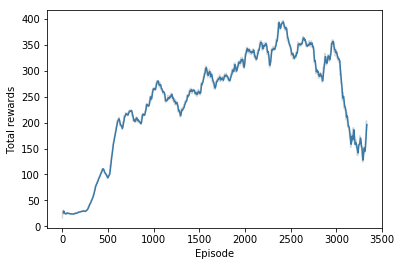

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

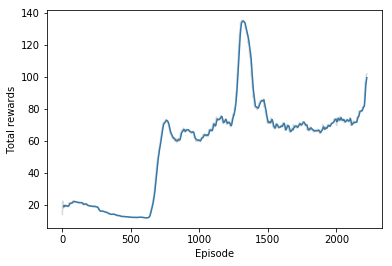

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

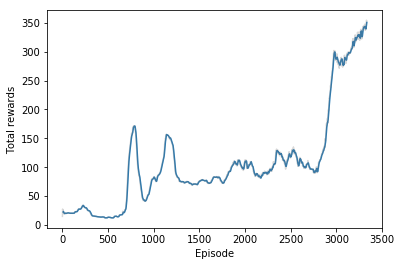

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

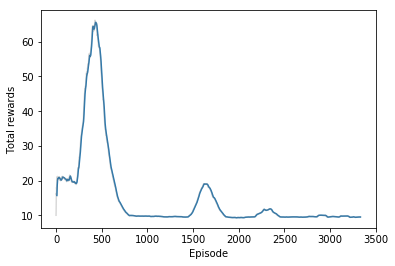

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

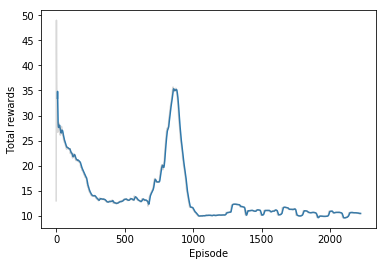

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

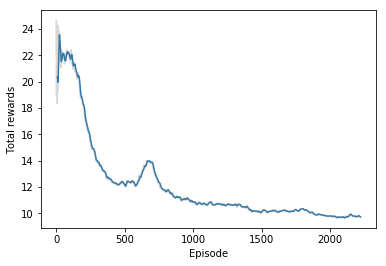

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

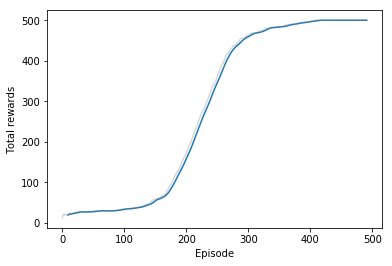

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

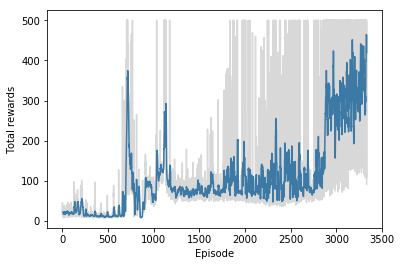

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

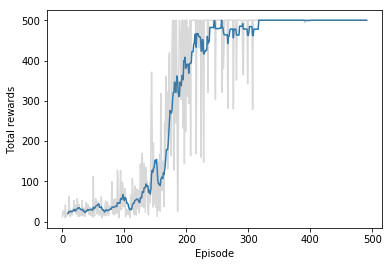

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.